In [5]:
from sys import platform as _platform
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
#if _platform =='linux2':
#    path = '../data/data_sleep/' 
#else:
#    #mets ton path ici et ça devrait marcher :)
#    path = ""
path = "data/"

In [ ]:
"data/stats_eeg_test.csv"

In [8]:
#frequencies=pd.read_csv(path+"data_frequences.csv").drop("Unnamed: 0", axis=1)
frequencies=pd.read_csv(path+"fft_eeg.csv")
frequencies_acc =pd.read_csv(path+"fft_acc.csv")

stats_acc=pd.read_csv(path+"stats_acc.csv")
stats_egg=pd.read_csv(path+"stats_egg.csv")
stats=pd.concat([stats_acc, stats_egg], axis=1)
#ACC_feats =pd.read_csv(path+"ACC_feats.csv").drop("Unnamed: 0", axis=1)
labels=pd.read_csv(path+"challenge_output_data_training_file_sleep_stages_classification.csv", sep=";")
#stats = pd.concat([stats.filter(regex="EEG[0-9]*"),stats_ACC], axis=1)
#stats = pd.concat([stats,stats_ACC], axis=1)

frequencies_test=pd.read_csv(path+"fft_eeg_test.csv")
frequencies_acc_test =pd.read_csv(path+"fft_acc_test.csv")
#ACC_feats_test =pd.read_csv(path+"ACC_feats_test.csv").drop("Unnamed: 0", axis=1)
stats_acc_test=pd.read_csv(path+"stats_acc_test.csv")
stats_egg_test=pd.read_csv(path+"stats_eeg_test.csv")
stats_test=pd.concat([stats_acc_test, stats_egg_test], axis=1)

In [3]:
def select_freq_names(low, high, X_columns, prefix = ''):
    return [name for name in X_columns 
            if len(name.split('q'))==2 
            and name.split('freq')[0] == prefix
            and low<=float(name.split('freq')[1]) 
            and high>= float(name.split('freq')[1])]
def group_frequencies(name, low, high, frequencies, prefix = ''):
    frequencies[name]=(1./(high-low) * (frequencies[select_freq_names(low,high,frequencies.columns,prefix)])).sum(axis=1)

In [4]:

#frequencies["delta"]=frequencies[select_freq_names(0,3,frequencies.columns)].sum(axis=1)
#frequencies["delta"]=frequencies[select_freq_names(0,3.99,frequencies.columns)].sum(axis=1)
#frequencies["theta"]=frequencies[select_freq_names(4,7.5,frequencies.columns)].sum(axis=1)
#frequencies["alpha"]=frequencies[select_freq_names(7.5,13.99,frequencies.columns)].sum(axis=1)
#frequencies["beta"]=frequencies[select_freq_names(14,50,frequencies.columns)].sum(axis=1)

def make_new_feats(frequencies):
    group_frequencies("delta1", 0.4, 0.8, frequencies)
    group_frequencies("delta2", 0.81, 1.99, frequencies)
    group_frequencies("delta3", 2, 3.99, frequencies)
    group_frequencies("theta1", 4, 5, frequencies)
    group_frequencies("theta2", 5, 7.499, frequencies)
    group_frequencies("alpha1", 7.5, 9.5, frequencies)
    group_frequencies("alpha2", 9.5, 10.499, frequencies)
    group_frequencies("alpha3", 10.5, 13.5, frequencies)
    group_frequencies("beta", 14, 20, frequencies)
    group_frequencies("beta2", 20, 30, frequencies)
    group_frequencies("beta3", 31, 50, frequencies)



In [5]:
def regroup_acc_freq (frequencies_acc):
    for prefix in ['ACC_X.','ACC_Y.','ACC_Z.']:
        group_frequencies(prefix+"smaller_one",0.01,1, frequencies_acc,prefix)
        group_frequencies(prefix+"one_to_two",1.01,2, frequencies_acc,prefix)
        group_frequencies(prefix+"two_to_three",2.01,3, frequencies_acc,prefix)
        group_frequencies(prefix+"three_to_four",3.01,4, frequencies_acc,prefix)
        group_frequencies(prefix+"more_four",4,10, frequencies_acc,prefix)




In [6]:
def make_new_features(f, stat, f_acc):
    new_feat = ["delta1","delta2","delta3", 'theta1', 'theta2', 'alpha1','alpha2','alpha3', 'beta','beta2','beta3']
    make_new_feats(f)
    
    prefixes = ['ACC_X.','ACC_Y.','ACC_Z.']
    regroup_acc_freq (f_acc)
    frequencies_acc2 = f_acc[[prefix+ x for x in["smaller_one","one_to_two","two_to_three",'more_four']for prefix in prefixes]]
    
    return  pd.concat([f[new_feat], stat, frequencies_acc2], axis=1)

In [7]:
train = make_new_features(frequencies, stats, frequencies_acc)
test = make_new_features(frequencies_test, stats_test, frequencies_acc_test)

In [8]:
train.describe()

,delta1,delta2,delta3,theta1,theta2,alpha1,alpha2,alpha3,beta,beta2,beta3,0_quantile_EEG,10_quantile_EEG,20_quantile_EEG,30_quantile_EEG,40_quantile_EEG,50_quantile_EEG,60_quantile_EEG,70_quantile_EEG,80_quantile_EEG,90_quantile_EEG,100_quantile_EEG,0_quantile_ACC_Z,10_quantile_ACC_Z,20_quantile_ACC_Z,30_quantile_ACC_Z,40_quantile_ACC_Z,50_quantile_ACC_Z,60_quantile_ACC_Z,70_quantile_ACC_Z,80_quantile_ACC_Z,90_quantile_ACC_Z,100_quantile_ACC_Z,0_quantile_ACC_Y,10_quantile_ACC_Y,20_quantile_ACC_Y,30_quantile_ACC_Y,40_quantile_ACC_Y,50_quantile_ACC_Y,60_quantile_ACC_Y,70_quantile_ACC_Y,80_quantile_ACC_Y,90_quantile_ACC_Y,100_quantile_ACC_Y,0_quantile_ACC_X,10_quantile_ACC_X,20_quantile_ACC_X,30_quantile_ACC_X,40_quantile_ACC_X,50_quantile_ACC_X,60_quantile_ACC_X,70_quantile_ACC_X,80_quantile_ACC_X,90_quantile_ACC_X,100_quantile_ACC_X,mean_EEG,mean_ACC_Z,mean_ACC_Y,mean_ACC_X,var_EEG,var_ACC_Z,var_ACC_Y,var_ACC_X,skew_EEG,skew_ACC_Z,skew_ACC_Y,skew_ACC_X,kurt_EEG,kurt_ACC_Z,kurt_ACC_Y,kurt_ACC_X,through_0,ACC_X.smaller_one,ACC_Y.smaller_one,ACC_Z.smaller_one,ACC_X.one_to_two,ACC_Y.one_to_two,ACC_Z.one_to_two,ACC_X.two_to_three,ACC_Y.two_to_three,ACC_Z.two_to_three,ACC_X.more_four,ACC_Y.more_four,ACC_Z.more_four
count,3.112900e+04,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,3.112900e+04,3.112900e+04,3.112900e+04,3.112900e+04,31129.000000,3.112700e+04,31095.000000,3.105900e+04,31129.000000,3.112900e+04,3.112900e+04,3.112900e+04,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000,31129.000000
mean,2.180787e+05,66415.984901,25777.882487,16727.005791,12412.698942,10436.192508,9230.629203,7652.617749,4395.367835,3076.966534,2217.256648,-67.668904,-24.578816,-15.029817,-9.142491,-4.553969,-0.429837,3.709411,8.344859,14.295154,23.852064,70.926835,389079.403871,394942.680469,401722.919196,418578.215755,441054.816154,464406.560797,487958.291960,511829.372506,533244.536975,548457.120201,553119.307859,508458.001608,512433.331547,520669.693936,538912.377147,560303.097796,583160.354622,606010.389134,628979.842747,650082.743408,665331.568056,670117.303174,463043.459858,467174.530536,474999.947300,492067.066492,512800.096769,534592.475148,556714.590114,578462.955919,599379.979357,614626.710998,619450.027578,-0.307724,467403.641997,585548.917565,537272.507188,8.091409e+03,3.551936e+10,3.488588e+10,3.330232e+10,0.042390,-1.056223e+05,-44216.596762,-9.025399e+04,1.888080,4.234130e+12,7.224458e+13,-4.718321e+13,266.303897,55257.764563,59060.369738,68198.799131,45070.254993,46029.634280,52876.211177,58954.750214,60437.381404,57634.399315,6722.761692,6419.831198,7002.951855
std,1.049126e+06,401127.379008,193613.862060,130811.552912,90632.399730,65039.692153,55269.180990,46207.481534,33265.198819,22897.909771,14408.527366,332.438831,44.725172,16.280377,9.902244,5.071556,1.948052,4.814270,9.619773,15.967630,29.583928,955.988966,561598.622147,565504.824485,564376.304941,559270.237759,557448.144970,564465.259308,581027.070964,606772.710146,635475.764328,658244.766881,662057.095991,670905.568374,672213.290684,668321.467589,660155.944471,655888.106042,658494.868185,668761.620419,686526.242650,708558.016987,726915.544490,729208.429707,586520.188548,587923.7155

In [9]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
y_train = labels['TARGET']
X = train.drop(["skew_ACC_X","skew_ACC_Y", "skew_ACC_Z"], axis=1)
X_t = test.drop(["skew_ACC_X","skew_ACC_Y", "skew_ACC_Z"], axis=1)
#X, X_t, y_train, y_test = train_test_split(
#    X, labels["TARGET"], test_size=0.2)

scaler = StandardScaler().partial_fit(X)
scaler = StandardScaler().partial_fit(X_t)
X_train = scaler.transform(X)
X_test = scaler.transform(X_t)
X_columns = train.columns

In [10]:
%%time
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import cohen_kappa_score
et = ExtraTreesClassifier(random_state = 42,n_estimators=1000, max_depth= 29, n_jobs = 3, class_weight = 'balanced')
et.fit(X_train, y_train)
predicted_label = et.predict(X_test)

#print("Extra Random Trees - accuracy Score on test_data : ", accuracy_score(y_test, predicted_label))
#print("Extra Random Trees - kappa Score on test_data : ", cohen_kappa_score(y_test, predicted_label))
print("Extra Random Trees - kappa Score on train data : ", cohen_kappa_score(y_train, et.predict(X_train)))

('Extra Random Trees - kappa Score on train data : ', 0.99974887699192883)
CPU times: user 1min 57s, sys: 1.99 s, total: 1min 59s
Wall time: 41.7 s


In [11]:
#from sklearn.metrics import accuracy_score
#print("Extra Random Trees - accuracy Score on test_data : ", accuracy_score(y_test, predicted_label))
#print("Extra Random Trees - kappa Score on test_data : ", cohen_kappa_score(y_test, predicted_label))

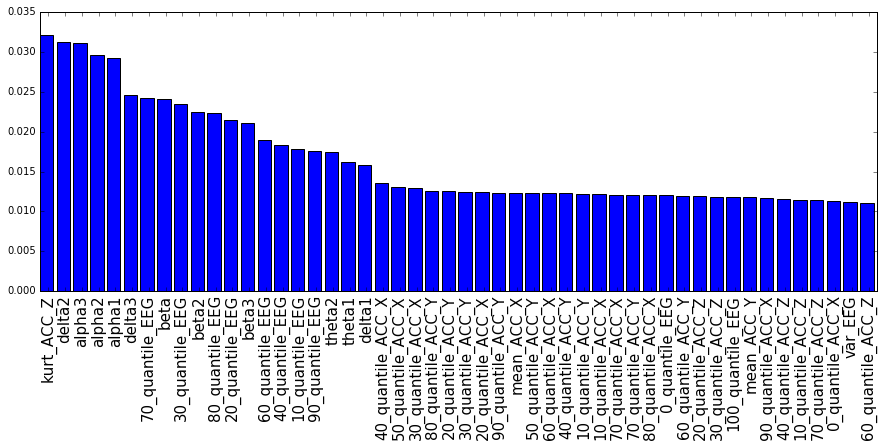

In [12]:
plt.figure(figsize=(15, 5))

ordering = np.argsort(et.feature_importances_)[::-1][:50]

importances = et.feature_importances_[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);

In [13]:
%%time
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(et, X_train, y_train, cv=5, scoring="accuracy",n_jobs=3)
print("accuracy: {:.4f} +/-{:.4f}".format(
    np.mean(scores), np.std(scores)))

accuracy: 0.8977 +/-0.0026
CPU times: user 189 ms, sys: 179 ms, total: 368 ms
Wall time: 2min 29s


In [14]:
def make_submission(predicted_label, name = 'submit.csv'):
    ids = pd.read_csv('../data/data_sleep/input_test.csv', usecols= ['ID'])
    ids["TARGET"] = pd.Series(predicted_label)
    ids['TARGET']= ids['TARGET'].astype(int)
    ids.to_csv(name,index=False)

In [15]:
make_submission(predicted_label)

In [16]:
predicted_label_train = et.predict(X_train)

In [17]:
import collections
print collections.Counter(predicted_label), collections.Counter(y_train)

Counter({2.0: 26010, 4.0: 2276, 3.0: 1598, 0.0: 493, 1.0: 81}) Counter({2.0: 15334, 3.0: 9640, 4.0: 4385, 0.0: 1342, 1.0: 428})


In [18]:
X_train.shape, X_test.shape

((31129, 81), (30458, 81))